In [1]:
%reset -f
import pandas as pd
import numpy as np
from wavhandler import *
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
mydata = Dataset('LG2/LG_suzukii_18_09_faulty')#'leek_leafminers')#'leafminer_all')#LG2/LG_suzukii_18_09_faulty')
mydata.load();

100%|██████████| 137/137 [00:06<00:00, 22.89it/s]


In [3]:
df_feats = mydata.get_sensor_features(temp_humd=False)
df_psd = make_df_parallel(names=mydata.filenames, setting='psd')

Text(0.5, 1.0, 'Signal counts for March')

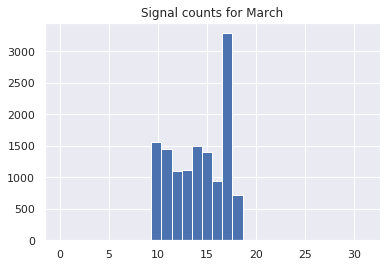

In [ ]:
df = pd.merge(df_feats.set_index('wavnames'), df_psd.T, left_index=True, right_index=True)
df.date_day.hist(bins=np.linspace(0,31,31))
plt.title('Signal counts for March')

### Data Table

In [ ]:
df.head(2)

,filenames,date,date_day,date_hour,gain,0,1,2,3,4,...,119,120,121,122,123,124,125,126,127,128
F180910_140040_043_G_120,/home/kalfasyan/data/insects/LG2/LG_suzukii_18...,2018-09-10 14:00:40,10,14,120,0.025380,0.168421,0.024079,0.003216,0.002830,...,0.000421,0.000365,0.000303,0.000295,0.000316,0.000310,0.000391,0.000339,0.000333,0.000177
F180910_140024_037_G_120,/home/kalfasyan/data/insects/LG2/LG_suzukii_18...,2018-09-10 14:00:24,10,14,120,0.040555,0.500514,0.053871,0.013565,0.008387,...,0.001103,0.001038,0.001309,0.001487,0.001224,0.001116,0.001019,0.000946,0.000969,0.000466


## In detail: Signals per day

In [ ]:
plt.figure(figsize=(20,12))
plt.tight_layout(True)
for w, (q,sub) in enumerate(df.groupby('date_day')):
    alldata = read_simple(sub.filenames.tolist())[0]
    allfreqs = []
    for i in range(alldata.shape[1]):
    #     plt.figure(figsize=(20,12))
        psd = power_spectral_density(alldata[:,i], bandpass=False, nfft=8192, noverlap=None)
        freq = psd.frequency.tolist()
        
    #     psd.pow_amp.plot()
        allfreqs = allfreqs + [freq[ii] for ii in peak_finder(psd) if ii > 70]
    plt.subplot(5,5,w+1)
    plt.title(str(q)+' day', y=0.8)
    plt.ylim(0,45)
    plt.hist(allfreqs, bins=np.linspace(0,500,25))

#     #     break

## In more detail: Signals per day and per hour

In [ ]:
plt.figure(figsize=(30,20))
for w, (q,sub) in enumerate(df.groupby(['date_day', 'date_hour'])):
    title = "day:{}, hour {}".format(sub.date_day.unique()[0], sub.date_hour.unique()[0])
    alldata = read_simple(sub.filenames.tolist())[0]
    allfreqs = []
    for i in range(alldata.shape[1]):
        psd = power_spectral_density(alldata[:,i], bandpass=False, nfft=8192, noverlap=None)
        freq = psd.frequency.tolist()
        allfreqs = allfreqs + [freq[ii] for ii in peak_finder(psd, h_threshold=0.01, d_threshold=3) if ii > 70]
    plt.subplot(6,7,w+1)
    plt.title(title, y=0.8)
    plt.ylim(0,12)
    plt.hist(allfreqs, bins=np.linspace(0,500,25))


### Some random PSD examples

In [ ]:
alldata = read_simple(df.filenames.tolist())[0]
plt.figure(figsize=(20,10))
for i in range(10):
    psd = power_spectral_density(alldata[:,i], bandpass=False, nfft=8192, nperseg=129, noverlap=None)
    freq = psd.frequency.tolist()
    plt.subplot(3,4,i+1)
    psd.pow_amp.plot()

## PCA on dB signal to see if we get groupings

In [ ]:
df_pca = make_df_parallel(names=mydata.filenames, setting='psd_dB')
print(df_pca.shape)
df_pca.head()

In [ ]:
df_pca.iloc[:,np.random.randint(0,175)].plot()

In [ ]:
# df_pca.columns = df.index
# df_pca.head()
df.date_day.values.shape
# X.shape
yy = df.date_day.values
yy.shape

In [ ]:
X = df_pca.T.values
print(X.shape)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data
print(X_std.shape)
ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
X_final = pca.fit_transform(X_std)
print(X_final.shape)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )
print(df.date_day.shape)
plt.figure(figsize=(10,8))
sns.set_style("darkgrid", {'axes.grid' : False})
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.8, legend='full', hue=yy, palette=sns.color_palette("gist_earth_r", len(np.unique(yy)))) 

plt.xlabel('component 1')
plt.ylabel('component 2')

## Transfer Learning

In [ ]:
from utils import *
from keras.models import model_from_yaml
from wavhandler import read_simple
model_name = 'raw_LG'
yaml_file = open(TEMP_DATADIR + model_name + '.yaml', 'r')
model = yaml_file.read()
yaml_file.close()
model = model_from_yaml(model)

In [ ]:
model.load_weights(TEMP_DATADIR + model_name + '_weights.h5')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
data = read_simple(df.filenames)[0].T
data = np.expand_dims(data, axis=-1)

In [ ]:
d = model.predict(data)

In [ ]:
d.shape

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(d[:,0], d[:,1], alpha=0.6)
plt.xlabel('Neuron 1')
plt.ylabel('Neuron 2')

In [ ]:
plt.hist(d[:,0]); plt.title('Neuron 1')

In [ ]:
plt.hist(d[:,1]); plt.title('Neuron 2')

In [ ]:
from scipy.special import softmax
df['label'] = np.argmax(softmax(d, axis=1), axis=1)

In [ ]:
df.sample(5)

In [ ]:
zz = 0

In [ ]:
yday = (df.date_day <= zz).astype(int)
hue = {'day': yday, 'deep': df.label}
hue = hue['deep']

X = df_pca.T.values
print(X.shape)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data
print(X_std.shape)
ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
X_final = pca.fit_transform(X_std)
print(X_final.shape)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )
print(df.date_day.shape)
plt.figure(figsize=(10,8))
sns.set_style("darkgrid", {'axes.grid' : False})
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.4, legend='full', palette=sns.color_palette("Paired", len(np.unique(hue))), hue=hue)#df.label)#yday)#
plt.title(zz)
plt.xlabel('component 1')
plt.ylabel('component 2')
zz += 1

In [ ]:
df.label.value_counts()

### Using a network trained on 6 mosquito classes and 2 drosophila classes

In [ ]:
from utils import *
from keras.models import model_from_yaml
from wavhandler import read_simple
model_name = 'raw_BIG'
yaml_file = open(TEMP_DATADIR + model_name + '.yaml', 'r')
model = yaml_file.read()
yaml_file.close()
model = model_from_yaml(model)

In [ ]:
model.load_weights(TEMP_DATADIR + model_name + '_weights.h5')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
data = read_simple(df.filenames)[0].T
data = np.expand_dims(data, axis=-1)

In [ ]:
d = model.predict(data)

In [ ]:
d.shape

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(d)


In [ ]:
pd.Series(kmeans.labels_).value_counts()

In [ ]:
yday = (df.date_day <= zz).astype(int)
hue = {'day': yday, 'deep': kmeans.labels_}
hue = hue['deep']

X = d
print(X.shape)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=True).fit_transform(X);  # standardization of data
print(X_std.shape)
ncomps = 2
pca = PCA(n_components=ncomps)
X_final = pca.fit_transform(X_std)
X_final[40,:] = X_final[40,:]/X_final[40,:] # NOTE: THIS IS TEMPORARY TO REMOVE/CHANGE OUTLIER

print(X_final.shape)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )
print(df.date_day.shape)
plt.figure(figsize=(10,8))
sns.set_style("darkgrid", {'axes.grid' : False})
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.8, legend='full', palette=sns.color_palette("cubehelix", len(np.unique(hue))), hue=hue)#df.label)#yday)#
plt.title(zz)
plt.xlabel('component 1')
plt.ylabel('component 2')

In [ ]:
plt.hist(np.mean(X_final, axis=1))
plt.ylim(0,10)

In [ ]:
np.argmax(np.mean(X_final, axis=1))

In [ ]:
print(X_final.shape)
np.delete(X_final, 40, axis=0).shape
#print(X_final.shape)